# Neural Density Estimation (with Mixture Density Networks)

In [ ]:
# install sbi and dependencies
import sys
!{sys.executable} -m pip install sbi

In [9]:
import torch

import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal, OneHotCategorical
from torch.optim import Adam

import matplotlib.pyplot as plt

from torch import Tensor
from typing import Tuple, Any

![MDN](figures/mdn.png)

In [10]:
# Adapted from https://github.com/tonyduan/mdn

class MixtureDensityNetwork(nn.Module):
    r"""
    Mixture density network.
    [Bishop, 1994](https://publications.aston.ac.uk/id/eprint/373/1/NCRG_94_004.pdf)

    Learn the conditional probability distribution p(y|x) parameterised as
    a mixture of Gaussians..

    Attributes:
        n_mixtures: Number of mixture components.
        coeffs_net: Neural net for estimating mixture components.
        normal_net: Neural net for estimating parameters of normal distributions.
    """
    def __init__(self, dim_in: int, dim_out: int, n_mixtures: int, dim_hidden: int = None):
        """
        Args:
            dim_in: dimensionality of the covariates.
            dim_out: dimensionality of the response variable.
            n_mixtures: number of components in the mixture model.
            dim_hidden: dimensionality of hidden units.
        """
        super().__init__()

        self.n_mixtures = n_mixtures
        if dim_hidden is None:
            dim_hidden = dim_in

        # learns the mixture coefficients
        self.coeffs_net = nn.Sequential(
            nn.Linear(dim_in, dim_hidden),
            nn.ELU(),
            nn.Linear(dim_hidden, n_mixtures)
        )

        # learns the distribution parameters
        self.normal_net = nn.Sequential(
            nn.Linear(dim_in, dim_hidden),
            nn.ELU(),
            nn.Linear(dim_hidden, 2 * dim_out * n_mixtures), # 2 => mean & var
        )

    def nnelu(self, x: Tensor) -> Tensor:
        """Numerically stabelised non negative exponential linear unit.
        """
        return F.elu(x)+1+1e-7
        
    def forward(self, x: Tensor) -> Tuple[OneHotCategorical, Normal]:
        """Model forward pass.
        
        Args:
            x: inputs.

        Returns:
            Mixture coefficients and normal distributions."""
        params = self.coeffs_net(x)
        mixing_coeffs = OneHotCategorical(logits=params) # Softmax

        params = self.normal_net(x)
        mean, sd = torch.split(params, params.shape[1] // 2, dim=1)
        mean = torch.stack(mean.split(mean.shape[1] // self.n_mixtures, 1))
        sd = torch.stack(sd.split(sd.shape[1] // self.n_mixtures, 1))
        normals = Normal(mean.transpose(0, 1), self.nnelu(sd).transpose(0, 1))

        return mixing_coeffs, normals

    def log_prob(self, x: Tensor, y: Tensor) -> Tensor:
        """Log likelihood of the model p(y|x)."""
        # log likelihood p(y|x)
        pis, normals = self.forward(x)
        loglik = normals.log_prob(y.unsqueeze(1).expand_as(normals.loc))
        loglik = torch.sum(loglik, dim=2)
        return torch.logsumexp(pis.logits + loglik, dim=1)

    def loss(self, x: Tensor, y: Tensor) -> Tensor:
        """Negative log likelihood."""
        return -self.log_prob(x,y)

    def sample(self, x: Tensor) -> Tensor:
        """Draw sample y for given input x."""
        pi, normal = self.forward(x)
        samples = torch.sum(pi.sample().unsqueeze(2) * normal.sample(), dim=1)
        return samples

# Toy Example

In [11]:
def toy_example(n: int = 1000, noise: bool = True) -> Tuple[Tensor, Tensor]:
    """Some generative process p(x,y).
    x and y are both 1d.

    y = [-1,1], x = 7sin(5y)+1/2*(y+eps), eps ~ N(0,1)
    
    Args:
        n: number of samples (x,y) to generate.
        noise: Whether to output ground truth of samples.
        
    Returns:
        Samples (x_i,y_i)"""
    y = torch.linspace(-1, 1, n)
    noise = noise*torch.randn_like(y)
    x = 7 * torch.sin(5 * y) + 0.5 * (y + noise)
    return x.view(-1,1), y.view(-1,1)

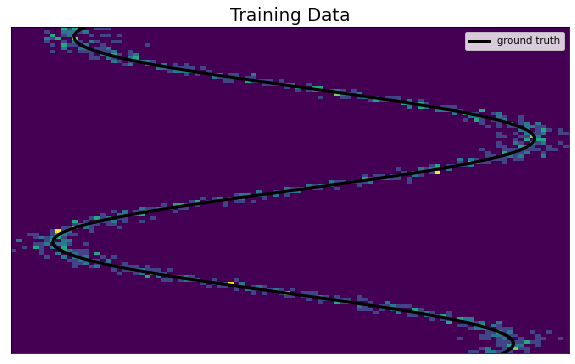

In [12]:
x_train, y_train = toy_example()
x_gt, y_gt = toy_example(noise=False)

plt.figure(figsize=(10,6))
plt.hist2d(x_train.view(-1).numpy(), y_train.view(-1).numpy(), bins=100)
plt.plot(x_gt,y_gt, c="k", lw=3, label="ground truth")
plt.title("Training Data", size=18)
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()

In [13]:
mdn = MixtureDensityNetwork(1,1,3)

In [14]:
# training the MDN
max_iter = 2000
optimizer = Adam(mdn.parameters(), lr=0.005)

for i in range(max_iter):
    optimizer.zero_grad()
    loss = mdn.loss(x_train, y_train).mean()
    loss.backward()
    optimizer.step()

In [15]:
# Validating the model
x_test, y_test = toy_example()
y_pred = mdn.sample(x_test)

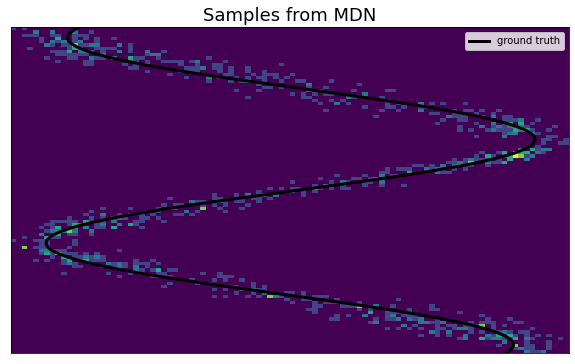

In [16]:
plt.figure(figsize=(10,6))
plt.title("Samples from MDN", size=18)
plt.hist2d(x_test.view(-1).numpy(), y_pred.view(-1).numpy(), bins=100)
plt.plot(x_gt, y_gt, c="k", lw=3, label="ground truth")
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()